/tmp/ipykernel_30067/171017678.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_success['下单时间'] = pd.to_datetime(data_success['下单时间'])


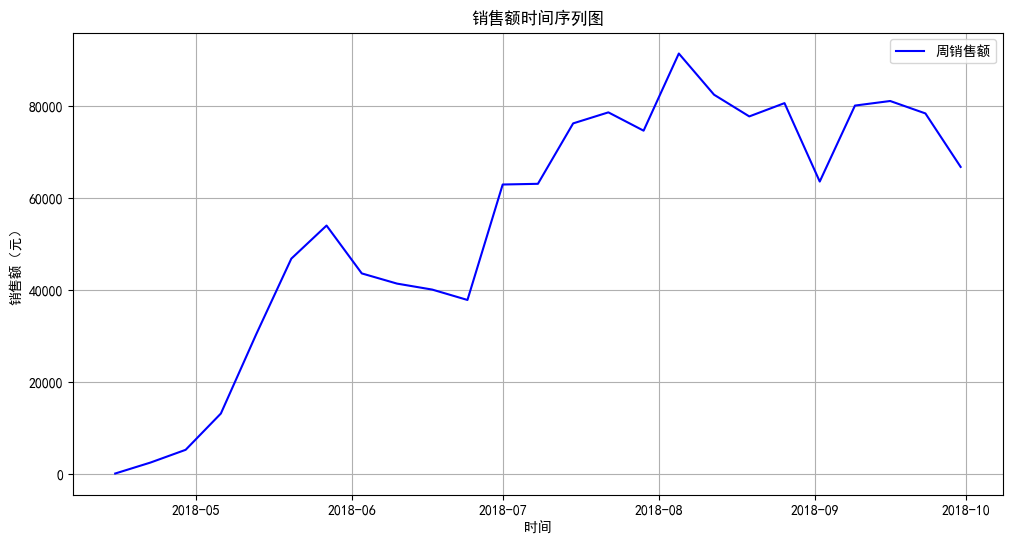

<Figure size 1200x600 with 0 Axes>

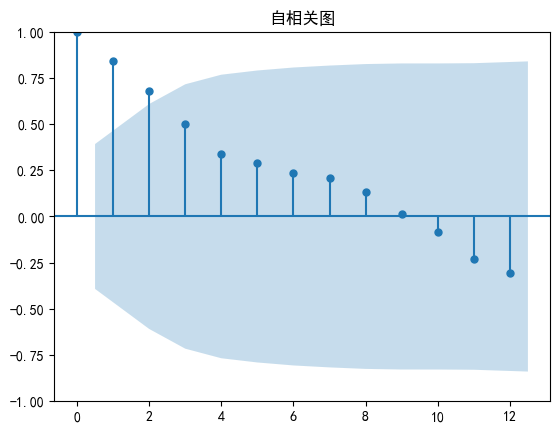

ADF检验结果:
检验统计量: -2.083664343138364
p 值: 0.2511337800343888
临界值: {'1%': np.float64(-3.7377092158564813), '5%': np.float64(-2.9922162731481485), '10%': np.float64(-2.635746736111111)}


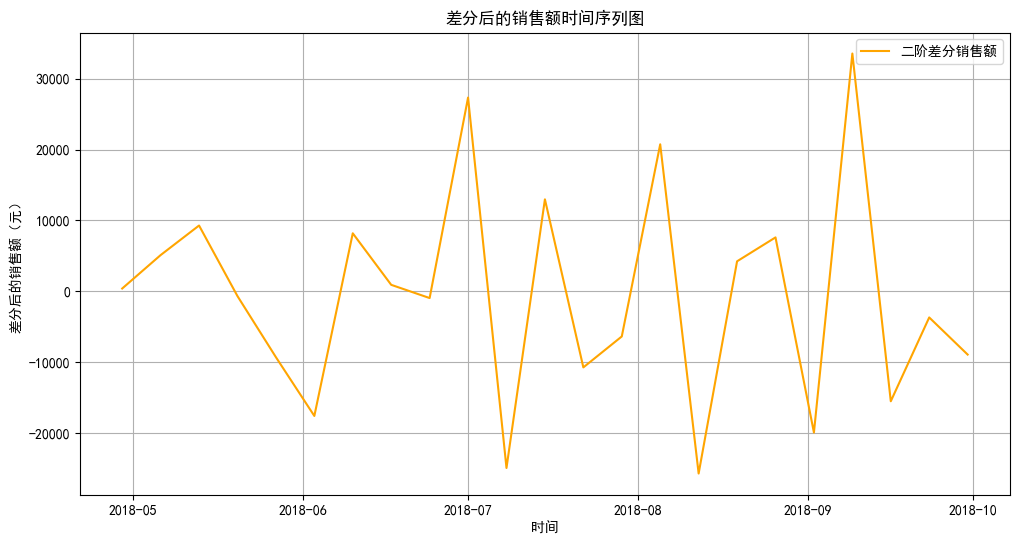

<Figure size 1200x600 with 0 Axes>

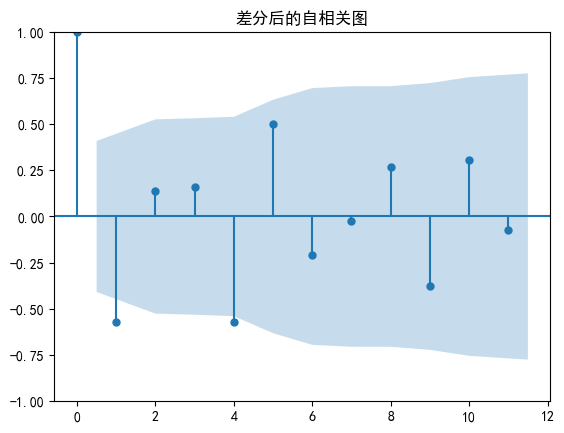

Ljung-Box检验结果:
      lb_stat  lb_pvalue
1    8.547701   0.003460
2    9.080960   0.010668
3    9.790670   0.020432
4   19.568560   0.000607
5   27.573073   0.000044
6   29.044573   0.000060
7   29.063684   0.000141
8   31.777062   0.000102
9   37.649796   0.000020
10  41.782222   0.000008
11  42.043930   0.000016
12  42.044056   0.000033
13  42.104006   0.000063
14  42.982933   0.000086
15  42.982942   0.000158
16  42.986149   0.000281
17  43.547839   0.000399
18  43.589836   0.000660
19  43.623514   0.001064
20  43.713989   0.001643


/home/zwh/miniconda3/envs/DataMining/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


最佳ARIMA模型参数(p, d, q): (0, 2, 1)
未来4周的销售额预测结果:
第1周预测销售额: 68653.46 元
置信区间: [47490.42493076829, 89816.50202281689] 元
第2周预测销售额: 70516.94 元
置信区间: [39709.101641179805, 101324.77226599048] 元
第3周预测销售额: 72380.41 元
置信区间: [33571.39442158922, 111189.42643916619] 元
第4周预测销售额: 74243.88 元
置信区间: [28186.100672781904, 120301.6671415586] 元


/home/zwh/miniconda3/envs/DataMining/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


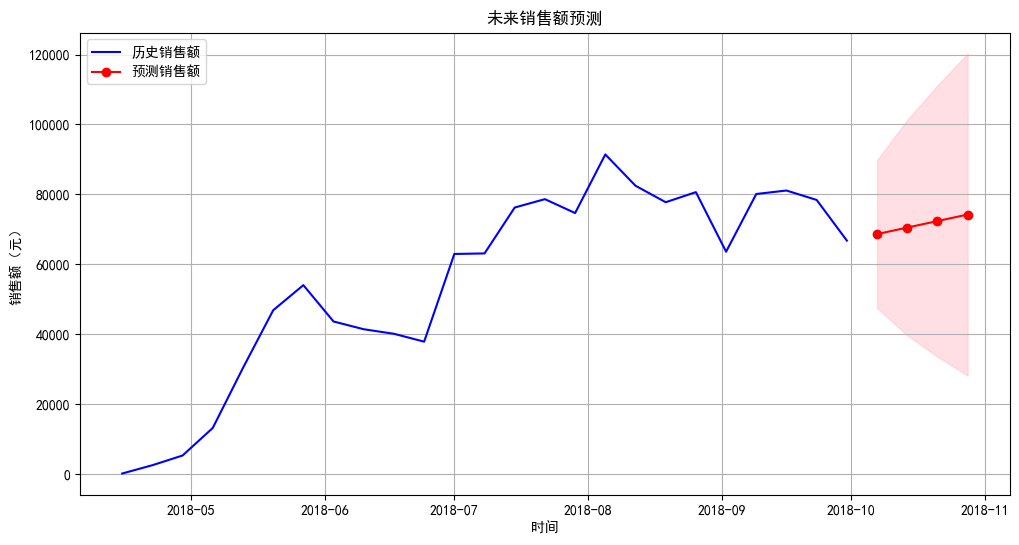

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置全局字体为SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

# 1. 读取数据
file_path = '../tmp/order.csv'
data = pd.read_csv(file_path, encoding='gbk')

# 2. 筛选出“出货成功”的记录
data_success = data[data['出货状态'] == '出货成功']

# 3. 将“下单时间”设置为索引并转换为日期格式
data_success['下单时间'] = pd.to_datetime(data_success['下单时间'])
data_success.set_index('下单时间', inplace=True)

# 4. 按周汇总“总金额（元）”
weekly_sales = data_success['总金额（元）'].resample('W').sum()

# 5. 可视化：时间序列图
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales, label='周销售额', color='blue')
plt.title('销售额时间序列图')
plt.xlabel('时间')
plt.ylabel('销售额（元）')
plt.legend()
plt.grid()
plt.show()

# 6. 自相关分析：绘制自相关图
plt.figure(figsize=(12, 6))
plot_acf(weekly_sales)
plt.title('自相关图')
plt.show()

# 7. 平稳性检验：使用 ADF 检验
adf_result = adfuller(weekly_sales)
print('ADF检验结果:')
print(f'检验统计量: {adf_result[0]}')
print(f'p 值: {adf_result[1]}')
print(f'临界值: {adf_result[4]}')

# 8. 差分处理：进行二阶差分
diff_sales = weekly_sales.diff().diff().dropna()

# 9. 再次可视化差分后的时间序列图
plt.figure(figsize=(12, 6))
plt.plot(diff_sales, label='二阶差分销售额', color='orange')
plt.title('差分后的销售额时间序列图')
plt.xlabel('时间')
plt.ylabel('差分后的销售额（元）')
plt.legend()
plt.grid()
plt.show()

# 10. 自相关图：差分后的数据
plt.figure(figsize=(12, 6))
plot_acf(diff_sales)
plt.title('差分后的自相关图')
plt.show()

# 11. 白噪声检验：Ljung-Box 检验
ljung_box_result = acorr_ljungbox(diff_sales, lags=20)
print('Ljung-Box检验结果:')
print(ljung_box_result)

# 12. 模型选择：使用 BIC 选择 ARIMA 模型参数
best_bic = np.inf
best_order = None
p_values = range(0, 4)
d_values = [2]  # 因为我们已经进行二阶差分
q_values = range(0, 4)

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(weekly_sales, order=(p, 2, q))
            results = model.fit()
            if results.bic < best_bic:
                best_bic = results.bic
                best_order = (p, 2, q)
        except:
            continue

print(f'最佳ARIMA模型参数(p, d, q): {best_order}')

# 13. 模型拟合与预测
model = ARIMA(weekly_sales, order=best_order)
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=4)
forecast_index = pd.date_range(start=weekly_sales.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 14. 输出预测结果
print('未来4周的销售额预测结果:')
for i, value in enumerate(forecast_values):
    print(f'第{i + 1}周预测销售额: {value:.2f} 元')
    print(f'置信区间: {forecast_conf_int.iloc[i].to_list()} 元')

# 15. 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales, label='历史销售额', color='blue')
plt.plot(forecast_index, forecast_values, label='预测销售额', color='red', marker='o')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.5)
plt.title('未来销售额预测')
plt.xlabel('时间')
plt.ylabel('销售额（元）')
plt.legend()
plt.grid()
plt.show()
